In [1]:
import json
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-12-02 21:45:30.965834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
JSON_PATH = "./data/mfcc_2022-12-02.json"

with open(JSON_PATH, "r") as fp:
    data_l = json.load(fp)

In [3]:
data_l["process_info"]

{'method': 'mfcc',
 'duration': 23,
 'n_fft': 512,
 'sample_rate': 22050,
 'trim': 'True',
 'zero-pad': 'True'}

In [4]:
DATASET_PATH = "./data/filtered"
if '.DS_Store' in os.listdir(DATASET_PATH):
    os.remove(f'{DATASET_PATH}/.DS_Store')

languages = os.listdir(DATASET_PATH)

In [5]:
def prepare_datasets(data, method, test_size, validation_size):
    """
    Loads data and splits it into train, validation and test sets
    """

    # load data
    X = np.array(data[method])
    y = np.array(data["labels"])

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets (aka channel for image)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(data_l, "mfcc", 0.25, 0.2)

In [7]:
# shape (`batch_size`, `height`, `width`, `channels`)
X_train.shape, X_val.shape, X_test.shape

((84, 991, 13, 1), (21, 991, 13, 1), (35, 991, 13, 1))

In [8]:
def plot_history(history):
    """
    Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="upper right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="lower right")
    axs[1].set_title("Error eval")

    plt.show()

In [9]:
def plot_confusion_matrix(model, X_test, languages):
    """
    Plots confusion matrix for model prediction on test 
    """

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=languages,
                yticklabels=languages,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

# Training: CNN v1

the following architecture is taken from [Sound of AI tutorial](https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/16-%20How%20to%20implement%20a%20CNN%20for%20music%20genre%20classification/code/cnn_genre_classifier.py) on music genre classification

In [10]:
input_shape = X_train.shape[1:]
input_shape

(991, 13, 1)

In [11]:
NUM_LABELS = 4

model = Sequential()

# 1st conv layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd conv layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd conv layer
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

# flatten output and feed it into dense layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(NUM_LABELS, activation='softmax'))

2022-12-02 21:45:39.551508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
optimiser = Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 989, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 495, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 495, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 493, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 247, 2, 32)       0         
 2D)                                                             
                                                        

In [13]:
NUM_EPOCHS = 15
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=NUM_EPOCHS)

Epoch 1/15
3/3 [==============================] - 2s 271ms/step - loss: 2.0180 - accuracy: 0.2738 - val_loss: 9.7743 - val_accuracy: 0.4286
Epoch 2/15
3/3 [==============================] - 1s 158ms/step - loss: 1.8314 - accuracy: 0.3690 - val_loss: 7.1768 - val_accuracy: 0.4286
Epoch 3/15
3/3 [==============================] - 0s 156ms/step - loss: 1.5456 - accuracy: 0.4167 - val_loss: 5.6945 - val_accuracy: 0.4286
Epoch 4/15
3/3 [==============================] - 0s 154ms/step - loss: 1.1720 - accuracy: 0.5714 - val_loss: 4.6404 - val_accuracy: 0.4286
Epoch 5/15
3/3 [==============================] - 1s 181ms/step - loss: 0.8910 - accuracy: 0.6905 - val_loss: 3.8375 - val_accuracy: 0.4286
Epoch 6/15
3/3 [==============================] - 1s 229ms/step - loss: 0.7927 - accuracy: 0.7143 - val_loss: 3.2483 - val_accuracy: 0.4286
Epoch 7/15
3/3 [==============================] - 1s 221ms/step - loss: 0.6010 - accuracy: 0.7976 - val_loss: 2.8472 - val_accuracy: 0.4286
Epoch 8/15
3/3 [====

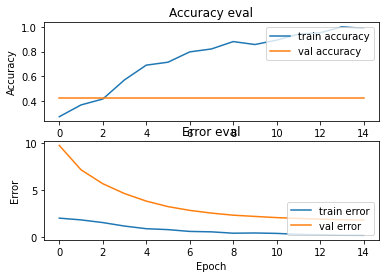

In [14]:
plot_history(history)

## Evaluation

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

2/2 - 0s - loss: 2.3793 - accuracy: 0.2000 - 74ms/epoch - 37ms/step


2/2 [==============================] - 0s 7ms/step


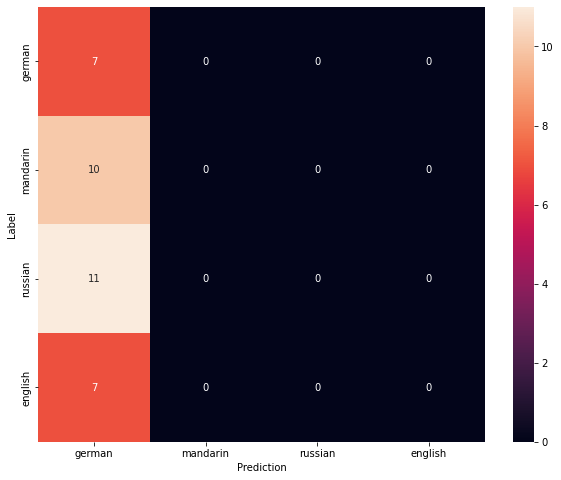

In [16]:
plot_confusion_matrix(model, X_test, languages)

# Training - CNN v2

the following architecture is taken from [Tensorflow tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio) on keywords (e.g. go, stop, left...) classification.

In [32]:
def build_model(input_shape,num_labels):
    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=X_train)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation="softmax"),
    ])

    return model

In [33]:
input_shape = X_train.shape[1:]

print('Input shape:', input_shape)
num_labels = 4

model = build_model(input_shape, num_labels)
model.summary()

Input shape: (991, 13, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)        

In [34]:
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [35]:
EPOCHS = 20
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
)

Epoch 1/20
3/3 [==============================] - 1s 125ms/step - loss: 1.5009 - accuracy: 0.2143 - val_loss: 1.3648 - val_accuracy: 0.4286
Epoch 2/20
3/3 [==============================] - 0s 70ms/step - loss: 1.3776 - accuracy: 0.3333 - val_loss: 1.4292 - val_accuracy: 0.1429
Epoch 3/20
3/3 [==============================] - 0s 66ms/step - loss: 1.3897 - accuracy: 0.3571 - val_loss: 1.3830 - val_accuracy: 0.2381
Epoch 4/20
3/3 [==============================] - 0s 74ms/step - loss: 1.3026 - accuracy: 0.4286 - val_loss: 1.3577 - val_accuracy: 0.3810
Epoch 5/20
3/3 [==============================] - 0s 69ms/step - loss: 1.3193 - accuracy: 0.3571 - val_loss: 1.3662 - val_accuracy: 0.2857
Epoch 6/20
3/3 [==============================] - 0s 67ms/step - loss: 1.2216 - accuracy: 0.5357 - val_loss: 1.3990 - val_accuracy: 0.2857
Epoch 7/20
3/3 [==============================] - 0s 67ms/step - loss: 1.2236 - accuracy: 0.5119 - val_loss: 1.3790 - val_accuracy: 0.2857
Epoch 8/20
3/3 [==========

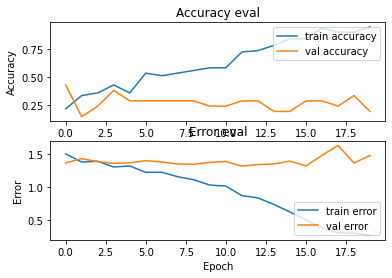

In [36]:
plot_history(history)

From history plots, looks like 10-12 epochs is the best.

In [39]:
model = build_model(input_shape, num_labels)
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
)

Epoch 1/10
3/3 [==============================] - 1s 177ms/step - loss: 1.7699 - accuracy: 0.2024 - val_loss: 1.4141 - val_accuracy: 0.2381
Epoch 2/10
3/3 [==============================] - 0s 67ms/step - loss: 1.3965 - accuracy: 0.2619 - val_loss: 1.3757 - val_accuracy: 0.1905
Epoch 3/10
3/3 [==============================] - 0s 66ms/step - loss: 1.3776 - accuracy: 0.2619 - val_loss: 1.3659 - val_accuracy: 0.1905
Epoch 4/10
3/3 [==============================] - 0s 71ms/step - loss: 1.3848 - accuracy: 0.2738 - val_loss: 1.3652 - val_accuracy: 0.4286
Epoch 5/10
3/3 [==============================] - 0s 69ms/step - loss: 1.3603 - accuracy: 0.3929 - val_loss: 1.3674 - val_accuracy: 0.4762
Epoch 6/10
3/3 [==============================] - 0s 80ms/step - loss: 1.3462 - accuracy: 0.4881 - val_loss: 1.3733 - val_accuracy: 0.2381
Epoch 7/10
3/3 [==============================] - 0s 71ms/step - loss: 1.3469 - accuracy: 0.4405 - val_loss: 1.3807 - val_accuracy: 0.3333
Epoch 8/10
3/3 [==========

## Evaluation

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

2/2 - 0s - loss: 1.3647 - accuracy: 0.4571 - 37ms/epoch - 18ms/step


## Confusion Matrix

2/2 [==============================] - 0s 4ms/step


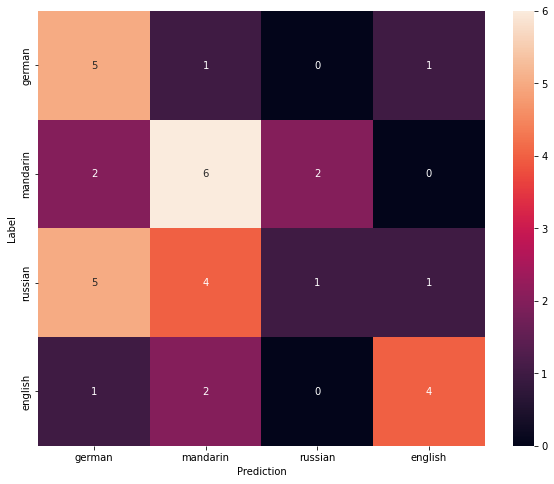

In [41]:
plot_confusion_matrix(model, X_test, languages)